# Analiza sentymentu wypowiedzi


Celem projektu jest zbudowanie modelu NLP do klasyfikacji emocji wyrażanych w krótkich tekstach (np. wypowiedziach użytkowników, postach w mediach społecznościowych, komentarzach).

W ramach realizacji projektu:
- przeprowadzono eksplorację zbioru danych,
- przygotowano dane do analizy (czyszczenie, tokenizacja, kodowanie etykiet),
- wytrenowano model bazujący na architekturze DistilBERT,
- oceniono skuteczność modelu na zbiorze testowym,
- wyciągnięto wnioski dotyczące wyników klasyfikacji.

Projekt stanowi kompletne rozwiązanie zadania klasyfikacji emocji z wykorzystaniem nowoczesnych metod przetwarzania języka naturalnego (NLP).


## Ustawienia środowiskowe

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# NLP Hugging Face
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

import sys
print(f"Python version: {sys.version}")


Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


## Biblioteki Kaggle

In [ ]:
!pip install kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

!unzip emotions-dataset-for-nlp.zip


mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
Archive:  emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


In [ ]:
train = pd.read_csv('train.txt', sep=';', header=None, names=['text', 'emotion'])
test = pd.read_csv('test.txt', sep=';', header=None, names=['text', 'emotion'])
val = pd.read_csv('val.txt', sep=';', header=None, names=['text', 'emotion'])

train = pd.concat([train, val])

train.head()


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Sprawdzenie liczby przykładów w zbiorze

In [ ]:
print(f"Liczba przykładów w zbiorze treningowym: {len(train)}")


Liczba przykładów w zbiorze treningowym: 18000


In [ ]:
print(f"Liczba przykładów w zbiorze testowym: {len(test)}")


Liczba przykładów w zbiorze testowym: 2000


emotion
joy         6066
sadness     5216
anger       2434
fear        2149
love        1482
surprise     653
Name: count, dtype: int64


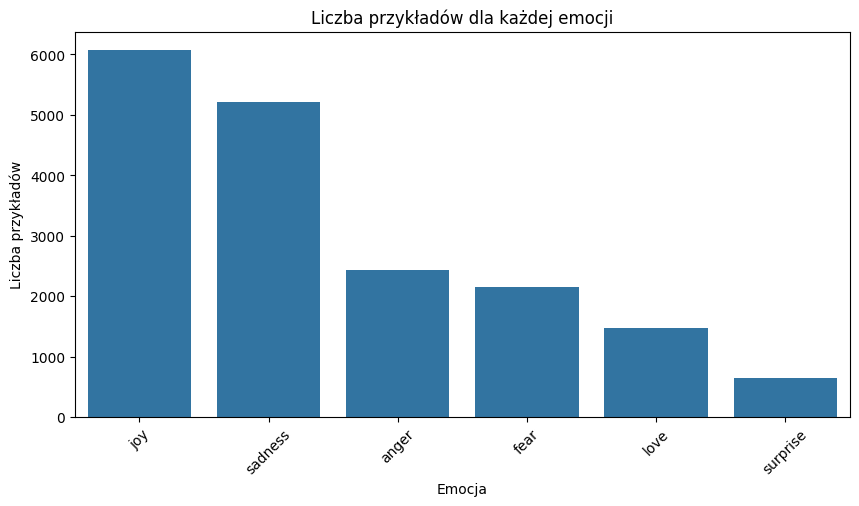

In [ ]:
# podsumowanie liczby przykładów dla każdej emocji
emotion_counts = train['emotion'].value_counts()

print(emotion_counts)

# wykres
plt.figure(figsize=(10,5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Liczba przykładów dla każdej emocji')
plt.xlabel('Emocja')
plt.ylabel('Liczba przykładów')
plt.xticks(rotation=45)
plt.show()


## Funkcja do czyszczenia tekstu

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

train.head()


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Zmiana etykiet emocji na wartości liczbowe

In [ ]:
# LabelEncoder
label_encoder = LabelEncoder()

train['label'] = label_encoder.fit_transform(train['emotion'])
test['label'] = label_encoder.transform(test['emotion'])

train[['emotion', 'label']].head()


,emotion,label
0,sadness,4
1,sadness,4
2,anger,0
3,love,3
4,anger,0


## Tokenizacja tekstu z użyciem DistilBERT

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train['text']), truncation=True, padding=True)

test_encodings = tokenizer(list(test['text']), truncation=True, padding=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Przygotowanie własnej klasy EmotionsDataset dla PyTorch

In [ ]:
import torch

class EmotionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionsDataset(train_encodings, list(train['label']))
test_dataset = EmotionsDataset(test_encodings, list(test['label']))


## Wczytanie modelu DistilBERT do klasyfikacji emocji

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_)
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Konfiguracja i uruchomienie treningu


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()


Step,Training Loss
50,1.434700
100,1.034100
150,0.652400
200,0.458700
250,0.355000
300,0.304200
350,0.393000
400,0.268900
450,0.249200
500,0.231000


TrainOutput(global_step=3375, training_loss=0.18918523622442174, metrics={'train_runtime': 476.1268, 'train_samples_per_second': 113.415, 'train_steps_per_second': 7.088, 'total_flos': 1215578579112000.0, 'train_loss': 0.18918523622442174, 'epoch': 3.0})

## Ewaluacja modelu

In [ ]:
from sklearn.metrics import accuracy_score

def compute_accuracy(preds, labels):
    preds = preds.argmax(axis=1)
    return accuracy_score(labels, preds)


## Predykcja na zbiorze testowym i obliczenie skuteczności

In [ ]:
predictions = trainer.predict(test_dataset)

accuracy = compute_accuracy(predictions.predictions, predictions.label_ids)
print(f"Dokładność modelu na zbiorze testowym: {accuracy:.4f}")


Dokładność modelu na zbiorze testowym: 0.9320


## Zapis wytrenowanego modelu i tokenizera

In [ ]:
model_path = "./saved_emotion_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("Model i tokenizer zostały zapisane!")


Model i tokenizer zostały zapisane!


## Definicja klasy EmotionClassifier do ładowania modelu i wykonywania predykcji

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch

class EmotionClassifier:
    def __init__(self, model_path):
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
        self.model.eval()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)

        labels = [label_encoder.inverse_transform([pred.item()])[0] for pred in predictions]
        return labels


## Testowanie modelu na przykładowych tekstach

In [ ]:
classifier = EmotionClassifier("./saved_emotion_model")

texts = [
    "I'm feeling fantastic today!",
    "I am so sad and heartbroken.",
    "I'm so angry right now!",
    "What a lovely surprise!",
    "I feel a bit scared about tomorrow."
]

predictions = classifier.predict(texts)
for text, emotion in zip(texts, predictions):
    print(f"Tekst: {text} ➔ Emocja: {emotion}")


Tekst: I'm feeling fantastic today! ➔ Emocja: joy
Tekst: I am so sad and heartbroken. ➔ Emocja: sadness
Tekst: I'm so angry right now! ➔ Emocja: anger
Tekst: What a lovely surprise! ➔ Emocja: love
Tekst: I feel a bit scared about tomorrow. ➔ Emocja: fear


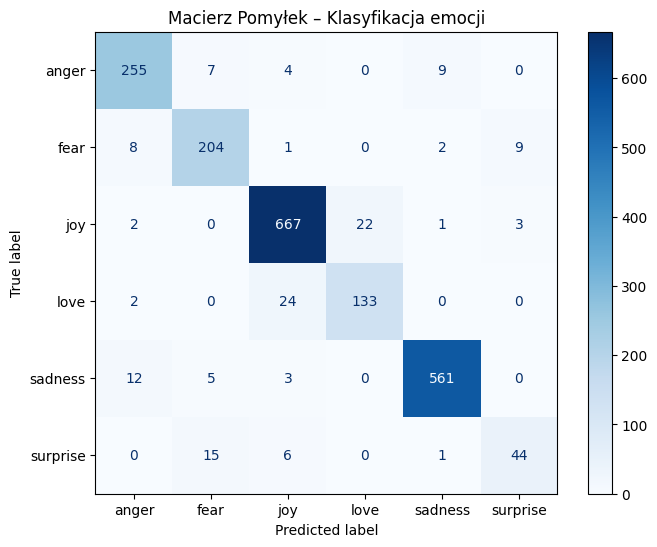

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# macierz pomyłek
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Macierz Pomyłek – Klasyfikacja emocji')
plt.show()






# Podsumowanie i wnioski

Model oparty na architekturze DistilBERT został wytrenowany do klasyfikacji emocji na podstawie tekstu.
Po przeprowadzeniu treningu na zbiorze danych, uzyskano następujące wyniki:

- Dokładność modelu na zbiorze testowym wyniosła **93,20%**.
- Model bardzo dobrze rozpoznaje emocje takie jak radość i smutek.
- Największe pomyłki obserwowano pomiędzy emocjami strachu i smutku, co jest zrozumiałe z perspektywy podobieństwa semantycznego tych stanów emocjonalnych.

**Wnioski:**
- Wybrany model DistilBERT jest odpowiedni do tego typu zadania i oferuje wysoką skuteczność przy umiarkowanym czasie trenowania.
- Dalsze ulepszenia mogłyby obejmować: rozbudowę zbioru treningowego, tunowanie hiperparametrów oraz zastosowanie bardziej zaawansowanych architektur modeli.
